In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib ipympl # for interactive plots
from pathlib import Path
import seaborn as sns
import umap
import time
import skdim
#import tensorflow as tf
#from tensorflow.keras import layers, models
#from keras_tuner import HyperModel, RandomSearch
from spatialinfo import spatial_information as si
from spatialinfo import dimensionality_utils as du
from spatialinfo import decoder as dc
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm


[Text(1, 0, '')]

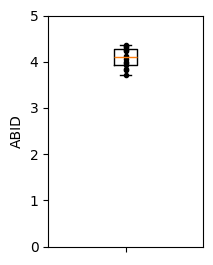

In [2]:
df = pd.read_csv("../results/manifold/dimensionality_summary.csv")
df.columns = ["dataset", "ABID"]

fig, ax = plt.subplots(figsize=(2, 3))
plt.boxplot(df.ABID)
plt.plot(np.ones(len(df.ABID)), df.ABID, 'k.')
ax.set_ylim([0,5])
ax.set_ylabel("ABID")
ax.set_xticklabels('')


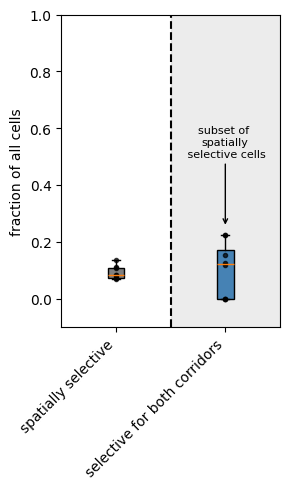

In [2]:
df = pd.read_excel('../results/fraction_spatial_coding.xlsx')
# Create figure
fig, ax = plt.subplots(figsize=(3, 5))
# Shade the background on the right side to match the second boxplot
ax.axvspan(1.5, 2.5, color='gray', alpha=0.15, zorder=0)
# Plot boxplots with subtle colors to indicate relationship
colors = ['gray', 'steelblue']
bp = plt.boxplot(
    [df['frac_spatial'], df['frac_both']],
    patch_artist=True
)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Overlay individual data points
plt.plot(np.ones(len(df.frac_spatial)), df.frac_spatial, 'k.', alpha=0.7)
plt.plot(np.ones(len(df.frac_both)) + 1, df.frac_both, 'k.', alpha=0.7)

# Add reference line
plt.vlines(1.5, -0.1, 1, 'k', linestyles="dashed")

# Axis formatting
ax.set_ylim([-0.1, 1])
ax.set_ylabel("fraction of all cells")

# Hierarchical x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels([
    "spatially selective",
    "selective for both corridors"
], rotation=45, ha='right')

# Annotation to clarify relationship
ax.annotate(
    "subset of \nspatially\n selective cells",
    xy=(2, 0.25), xytext=(2, 0.5),
    arrowprops=dict(arrowstyle="->", color="black"),
    ha='center', fontsize=8, color='black'
)

plt.tight_layout()
plt.savefig("../results/fraction_of_cells.svg")
plt.show()

In [11]:
df

,recording ID,n_neurons,n_spatially_selective,n_corr_1,n_corr_2,n_both,frac_spatial,frac_both
0,20250722_Dc_2,231,17,15,0,2,0.073593,0.117647
1,20250828_Dc_left,71,6,5,1,0,0.084507,0.000000
2,20250828_Dc_right,125,9,5,2,2,0.072000,0.222222
3,20240903_Dc_1,366,39,20,13,6,0.106557,0.153846
4,20240916_Dc_1,66,9,5,2,2,0.136364,0.222222
5,20240916_Dc_2,97,8,4,3,1,0.082474,0.125000
6,20240930_Dc_1,54,6,3,3,0,0.111111,0.000000
7,20241203_Dc,289,20,15,5,0,0.069204,0.000000


## LOAD DATA

In [43]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240930_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
activity_data, spatial_data = si.temporal_binning(dff, bh, sec_per_bin=0.2, only_moving=False)

In [41]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240930_Dc_1\\'))

bh.columns = ['timestamp', 'trial', 'trial index', 'X', 'Y', 'velocity',
       'tail tracking framecount']
activity_data, spatial_data = si.temporal_binning(dff, bh, sec_per_bin=0.2, only_moving=False)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 7 elements

In [44]:


def binning_function(behavior, sec_per_bin=0.5, fps=30, only_moving=False):
    """
    Bins occupancy and activity data into temporal bins.
    Assumes that distinct corridors are characterized by X position and
    that a trial column exists in behavior

    Parameters:
        dff (pandas.core.frame.DataFrame): df/f calcium imaging data
            (rows: time; columns: neurons)
        behavior (pandas.core.frame.DataFrame): contains X, Y columns with
            spatial information, trial column and frdIn with tail vigor
        sec_per_bin (int): how many seconds will be averaged into one bin,
            defaults to 1.
        fps (int): recording speed in frames per second, defaults to 30
        only_moving (bool): removing frames in which the animal is not moving,
            defaults to True.

    Returns:
        activity_data (np.ndarray): activity matrix after binning,
            columns = features, rows = bins
        spatial_data (np.ndarray): average position of animal during each bin,
            columns = X, Y, rows = bins
    """
    # Compute the number of frames per bin
    frames_per_bin = sec_per_bin * fps

    # remove frames in which the animal is not moving
    if only_moving:
        id_mask = behavior.Y.diff().values != 0
        behavior = behavior.loc[id_mask].reset_index()
    # Determine number of bins
    num_bins = int(np.ceil(len(behavior) / frames_per_bin))

    # Initialize lists to store binned data
    binned_spatial = []

    for i in range(num_bins):
        start_idx = math.floor(i * frames_per_bin)
        end_idx = math.ceil(min((i + 1) * frames_per_bin, len(behavior)))

        spatial_bin = behavior[["trial"]].iloc[start_idx:end_idx].mode(axis=0).values

        if np.any(np.diff(behavior.trial.iloc[start_idx:end_idx].values) != 0):
            continue
        else:
            binned_spatial.append(spatial_bin[0][0])

    # Convert lists to numpy arrays
    spatial_data = np.array(binned_spatial).astype(float)

    return spatial_data

binned_trials = binning_function(bh, sec_per_bin=0.2, only_moving=False)

In [45]:
# create trial time and session time variables
import itertools
j = 0
session_time = [j + i * 0.5 for i in range(len(binned_trials))]
trial_time = [i * 0.5 for group in itertools.groupby(binned_trials) for i, _ in enumerate(list(group[1]))]

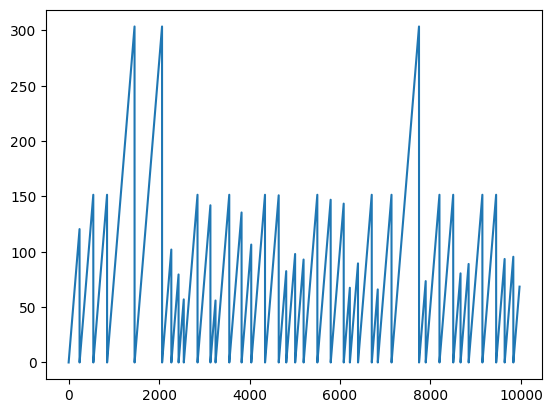

In [46]:
plt.plot(trial_time)

## COMPUTE DIMENSIONALITY
The angle-based intrinsic dimensionality (ABID) estimate was introduced by [Thordsen & Schubert (2022)](https://doi.org/10.1016/j.is.2022.101989). In short, for each point of a dataset x nearest neighbors are found according to some distance metric. From the paper:

"Definition 1 (ABID) . Given a data set $X = { x_1 , . . . , x_n }⊂ \mathbb{R}^D$ , the regularized angle-based intrinsic dimensionality estimator for a point x i is: $ID_{ABID}( x_i ; k ) := \mathbb{E} [ C_1 ( B_k ( x_i ))^2 ] ^{− 1}$ where $B_k ( x_i )$ are the directional vectors from $x_i$ to the k nearest neighbors of $x_i$ and $C_1 ( B_k ( x_i ))$ are the pairwise cosine similarities within $B_k ( x_i )$."

In [7]:

abid_dim = du.compute_abids(activity_data)
print(f"ABID: {np.nanmean(abid_dim):.2f}", end='', flush=True)
time.sleep(.2)
    
mom_dim = skdim.id.MOM().fit_transform(activity_data,n_neighbors = 25)
print(f" | MOM: {mom_dim:.2f}", end='', flush=True)
time.sleep(.2)

tle_dim = skdim.id.TLE().fit_transform(activity_data,n_neighbors = 25)
print(f" | TLE: {tle_dim:.2f}", flush=True)
time.sleep(.2)

ABID: 4.45

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
  File "c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical}

 | MOM: 8.55 | TLE: 8.10


In [6]:
# Dependency of ABID to temporal bin size - takes 28 minutes on a CPU
ABID_dep = []
for temp_bin in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]:
    activity_data_dep, spatial_data_dep = si.temporal_binning(dff, bh, sec_per_bin=temp_bin, only_moving=False)
    abid_dim_dep = du.compute_abids(activity_data_dep)
    ABID_dep.append(np.mean(abid_dim_dep))

plt.plot([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1], ABID_dep)

KeyboardInterrupt: 

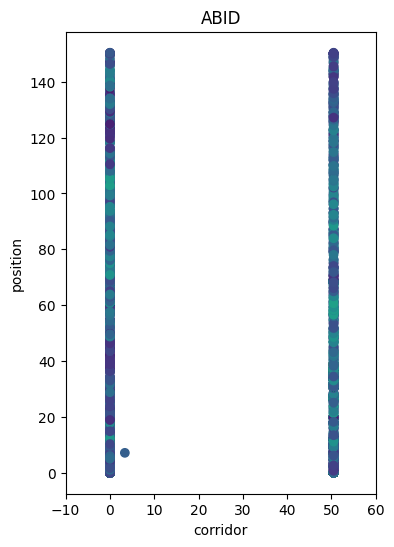

In [5]:
# display how ABID maps to behavior space

df = np.column_stack((spatial_data, abid_dim))

fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=df[:,0], y=df[:,1], c=df[:,2], cmap='viridis')
ax.set(title='ABID', xlabel='corridor', ylabel='position')
ax.set_xlim([-10,60])
plt.show()

## COMPUTE UMAP

In [47]:
#model = umap.UMAP(n_neighbors =50, n_components =3, min_dist=0.08, metric="correlation")
model = umap.UMAP(n_neighbors =30, n_components =3, min_dist=0.1, metric="correlation")
model.fit(activity_data)
concat_emb = model.transform(activity_data)
np.shape(spatial_data)

(9970, 2)

In [48]:
norm_trial = Normalize(vmin=np.min(trial_time), vmax=60)
norm_session = Normalize(vmin=np.min(session_time), vmax=np.max(session_time))

colors_trial = cm.viridis(norm_trial(trial_time))
colors_session = cm.viridis(norm_session(session_time))

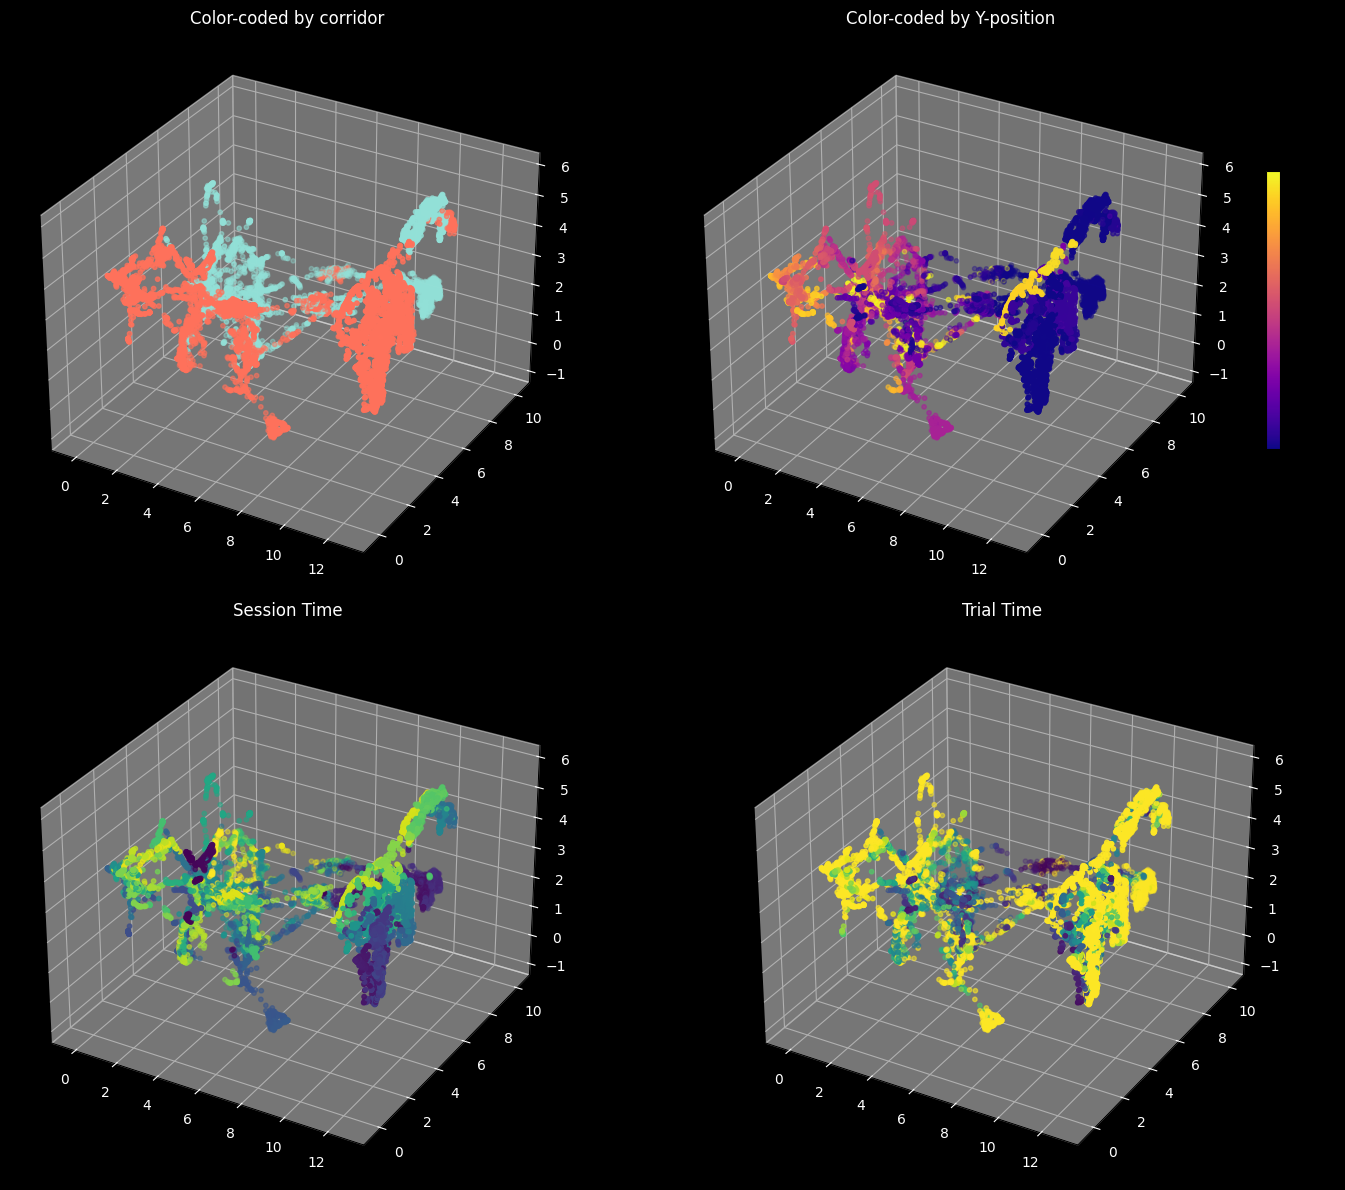

In [49]:
# Normalize x and y separately for color mapping
norm_x = Normalize(vmin=spatial_data[:, 0].min(), vmax=spatial_data[:, 0].max())
norm_y = Normalize(vmin=spatial_data[:, 1].min(), vmax=spatial_data[:, 1].max())

colors_x = cm.viridis(norm_x(spatial_data[:, 0]))  # Color by x
colors_y = cm.plasma(norm_y(spatial_data[:, 1]))  # Color by y



# Threshold X to assign binary groups (e.g., midpoint split)
x_values = spatial_data[:, 0]
x_threshold = np.mean(x_values)  # or pick a manual value
labels_x = x_values < x_threshold  # True for "right", False for "left"

# Define your two colors
teal = (0/255, 128/255, 128/255)
red = (200/255, 50/255, 50/255)

new_red = (255/255, 113/255, 91/255)
new_teal = (147/255, 225/255, 216/255)

# Map binary labels to RGB colors
colors_rgb = np.where(labels_x[:, None], new_red, new_teal)

# Filter points where x = 0 and x ≠ 0
mask_x0 = spatial_data[:, 0] == 0
mask_x_nonzero = spatial_data[:, 0] != 0

# Create figure and 3D subplots
fig = plt.figure(figsize=(15, 12), facecolor='black')

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(221, projection='3d', facecolor='black')
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_rgb, s=10)
ax1.set_title("Color-coded by corridor", color='white')
# Set white for all axis lines and ticks
ax1.tick_params(colors='white')  # Ticks
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.zaxis.label.set_color('white')

# Subplot 2: Color-coded by y-position
ax2 = fig.add_subplot(222, projection='3d', facecolor='black')
sc2 = ax2.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_y, s=10)
ax2.set_title("Color-coded by Y-position", color='white')
ax2.tick_params(colors='white')  # Ticks
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.zaxis.label.set_color('white')

# Add colorbar for y
sm_y = cm.ScalarMappable(cmap="plasma", norm=norm_y)
sm_y.set_array([])
cbar_y = plt.colorbar(sm_y, ax=ax2, shrink=0.5)
cbar_y.set_label("Y Position")

# Subplot 3: colored by session time
ax3 = fig.add_subplot(223, projection='3d', facecolor='black')
sc3 = ax3.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], 
                  c=colors_session, s=10)
ax3.set_title("Session Time", color='white')
ax3.tick_params(colors='white')  # Ticks
ax3.xaxis.label.set_color('white')
ax3.yaxis.label.set_color('white')
ax3.zaxis.label.set_color('white')

# Subplot 4: Only x ≠ 0, color-coded by y-position
ax4 = fig.add_subplot(224, projection='3d', facecolor='black')
sc4 = ax4.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], 
                  c=colors_trial, s=10)
ax4.set_title("Trial Time", color='white')
ax4.tick_params(colors='white')  # Ticks
ax4.xaxis.label.set_color('white')
ax4.yaxis.label.set_color('white')
ax4.zaxis.label.set_color('white')

plt.tight_layout()
plt.show()

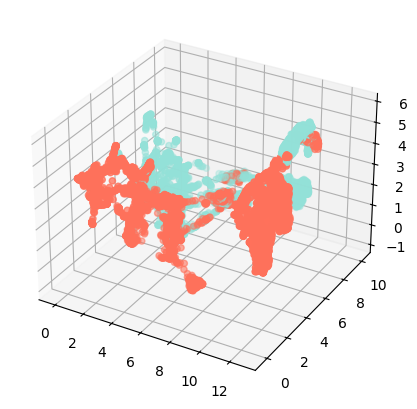

In [51]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(5,5), facecolor='white')

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(111, projection='3d', facecolor='white')
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_rgb, s=20)
#ax1.set_title("Color-coded by corridor", color='black')
# Set white for all axis lines and ticks
ax1.tick_params(colors='black')  # Ticks
ax1.xaxis.label.set_color('black')
ax1.yaxis.label.set_color('black')
ax1.zaxis.label.set_color('black')

plt.savefig("../results/UMAP_20240930_Dc_1.svg")

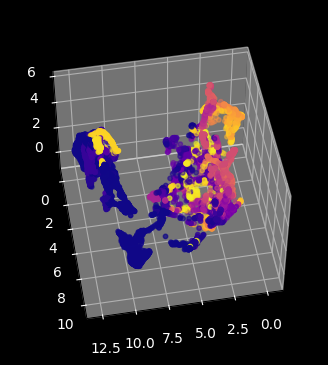

In [52]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(4, 4), facecolor='black')

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(111, projection='3d', facecolor='black')
ax1.view_init(elev=50, azim=80)  # 20° above, 15 rotated horizontally
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_y, s=10)
ax1.set_title("Color-coded by X-position")
# Set white for all axis lines and ticks
ax1.tick_params(colors='white')  # Ticks
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.zaxis.label.set_color('white')
# plt.savefig("../results/Dc_UMAP_new.png")



Another way to look at dimensionality of a dataset would be to look at the loadings of the principal components after projecting the data on orthogonal axes.

In [53]:
# start by MinMax-Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(activity_data.T)# Now, shape (n_samples, n_neurons)
# fit PCA transform
pca = PCA()
pca.fit(X)

PCA()

Text(0, 0.5, 'explained variance ratio')

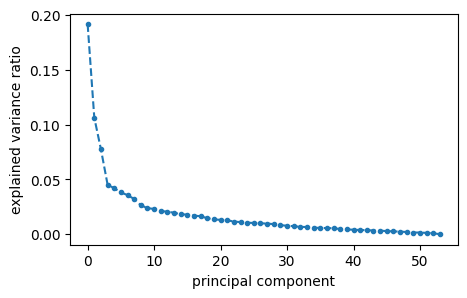

In [54]:
plt.figure(figsize=(5,3))
plt.plot(pca.explained_variance_ratio_, '.--')
plt.xlabel("principal component")
plt.ylabel("explained variance ratio")

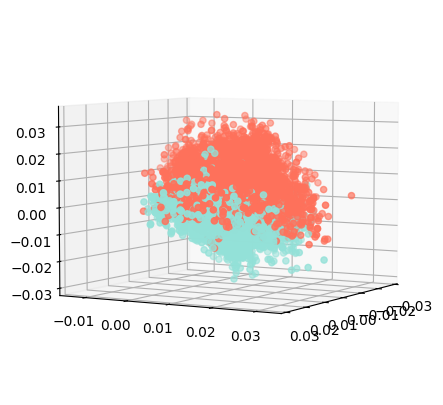

In [62]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(5,5), facecolor="white")

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(111, projection='3d', facecolor='white')
ax1.view_init(elev=5, azim=30)
ax1.scatter(pca.components_.T[:, 0], pca.components_.T[:, 1], pca.components_.T[:, 2], c=colors_rgb, s=20)

# Subplot 1: Color-coded by x-position
#ax2 = fig.add_subplot(122, projection='3d', facecolor='black')
#ax2.view_init(elev=15, azim=70)
#ax2.scatter(pca.components_.T[:, 0], pca.components_.T[:, 1], pca.components_.T[:, 2], c=colors_rgb, s=1)
# Remove axes, labels, and title
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.set_zticks([])
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
#ax1.set_zticklabels([])
#ax1.set_frame_on(False)
#ax1.grid(False)
#ax1.xaxis.pane.fill = False
#ax1.yaxis.pane.fill = False
#ax1.zaxis.pane.fill = False
#ax1.set_title("")  # Remove title
#ax1.axis('off')  # This removes all spines and ticks
plt.savefig("../results/PCA_20240930_Dc_1.svg")
plt.show()

In [63]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(X.T)

In [64]:
X_embedded.shape

(9970, 3)

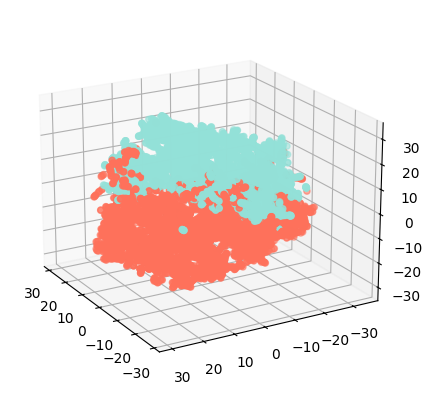

In [66]:
# Create figure and 3D subplots
fig = plt.figure(figsize=(5,5), facecolor='white')

# Subplot 1: Color-coded by x-position
#ax1 = fig.add_subplot(221, projection='3d')
# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(111, projection='3d', facecolor='white')
ax1.view_init(elev=20, azim=150)  # 20° above, 15 rotated horizontally
ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=colors_rgb, s=20)


#ax2 = fig.add_subplot(122, projection='3d', facecolor='black')
#ax2.view_init(elev=20, azim=150)  # 20° above, 15 rotated horizontally
#ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=colors_y, s=3)
# Remove axes, labels, and title
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.set_zticks([])
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
#ax1.set_zticklabels([])
#ax1.set_frame_on(False)
#ax1.grid(False)
#ax1.xaxis.pane.fill = False
#ax1.yaxis.pane.fill = False
#ax1.zaxis.pane.fill = False
#ax1.set_title("")  # Remove title
#ax1.axis('off')  # This removes all spines and ticks
plt.savefig("../results/tsne_20240930_Dc_1.svg")
plt.show()